クラス分類器の不確実性とは
---
- クラス分類器が出力した予測がどのくらい確かなのか？
- scikit-learnにはあるテストポイントに対して、クラス分類器の予測に対する不確実性を推定する機能がある
    - decision_function
    - predict_proba

In [1]:
from IPython.display import set_matplotlib_formats, display
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import mglearn
from cycler import cycler
from sklearn.model_selection import train_test_split
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

### GradientBoostingClassifier(勾配ブースティング)による動作の確認

In [2]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.datasets import make_circles
X, y = make_circles(noise=0.25, factor=0.5, random_state=1)

# わかりやすいようにクラスをblueとredにする
y_named = np.array(["blue", "red"])[y]

# train_test_splitは任意の数の配列に適用できる
#  すべての配列は整合するようの分割される
X_train, X_test, y_train_named, y_test_named, y_train, y_test = train_test_split(X, y_named, y, random_state=0)

# 勾配ブースティングモデルを構築
gbrt = GradientBoostingClassifier(random_state=0)
gbrt.fit(X_train, y_train_named)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=0, subsample=1.0, verbose=0,
              warm_start=False)

#### 決定関数(Decision Function)

In [3]:
print("X_test.shape: {}".format(X_test.shape))
print("Desicion function shape: {}".format(gbrt.decision_function(X_test).shape))

X_test.shape: (25, 2)
Desicion function shape: (25,)


- 2クラス分類の場合、decision_functionの結果の配列は(n_samples,)の形になり、サンプルごとに1つの浮動小数点数が返される
- この値には、あるデータポイントが「陽性」であるとモデルが信じている度合いがエンコードされている
    - 正であれば陽性クラス、負であれば陰性クラスを意味する

In [4]:
# decision_functionの最初のいくつかを表示
print("Decision function:\n{}".format(gbrt.decision_function(X_test)[:6]))

Decision function:
[ 4.13592629 -1.7016989  -3.95106099 -3.62599351  4.28986668  3.66166106]


In [5]:
print("Thresholded decision function:\n{}".format(gbrt.decision_function(X_test) > 0))
print("Predictions:\n{}".format(gbrt.predict(X_test)))

Thresholded decision function:
[ True False False False  True  True False  True  True  True False  True
  True False  True False False False  True  True  True  True  True False
 False]
Predictions:
['red' 'blue' 'blue' 'blue' 'red' 'red' 'blue' 'red' 'red' 'red' 'blue'
 'red' 'red' 'blue' 'red' 'blue' 'blue' 'blue' 'red' 'red' 'red' 'red'
 'red' 'blue' 'blue']


- 決定関数の符号だけ見れば予測クラスが分かる

In [6]:
# True/Falseを0/1に
greater_zero = (gbrt.decision_function(X_test) > 0).astype(int)
# 0/1をclasses_のインデックスに使う
pred = gbrt.classes_[greater_zero]
# predはgrbt.predictの出力と同じになる
print("pred is equal to predictions: {}".format(np.all(pred == gbrt.predict(X_test))))

pred is equal to predictions: True


- 2クラス分類では、「陰性」クラスがclasses_属性の第一エントリに「陽性」クラスが第2エントリになる

In [7]:
decision_function = gbrt.decision_function(X_test)
print("Decision function minimum: {:.2f} maximum: {:.2f}".format(np.min(decision_function), np.max(decision_function)))

Decision function minimum: -7.69 maximum: 4.29


- decision_functionのレンジは決まっておらず、データとモデルパラメータに依存する
- つまり、decision_functionの結果はどのようなスケールで表示されるかわからないため解釈が難しい

#### 決定境界と2次元平面上の全ての点に対するdecision_functionの値を色付け

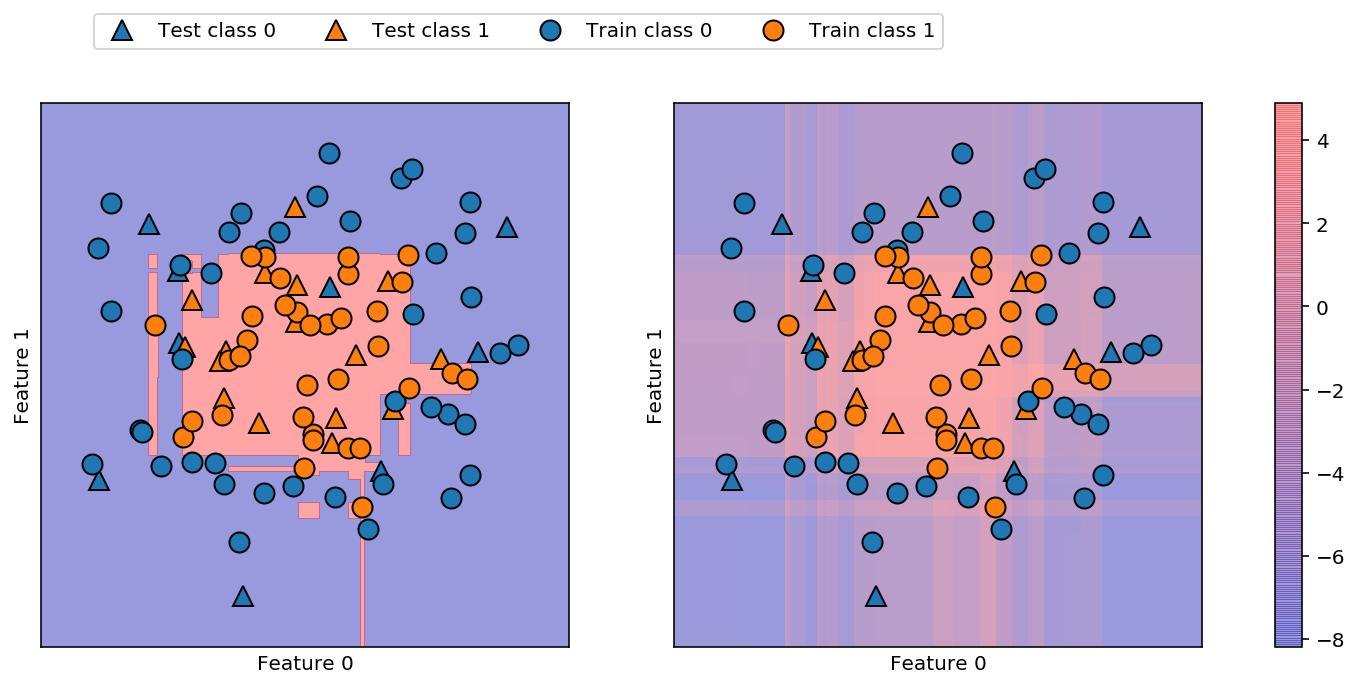

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(13, 5))
mglearn.tools.plot_2d_separator(gbrt, X, ax=axes[0], alpha=.4, fill=True, cm=mglearn.cm2)
scores_image = mglearn.tools.plot_2d_scores(gbrt, X, ax=axes[1], alpha=.4, cm=mglearn.ReBl)

for ax in axes:
    # 訓練データポイントとテストデータポイントをプロット
    mglearn.discrete_scatter(X_test[:, 0], X_test[:, 1], y_test, markers='^', ax=ax)
    mglearn.discrete_scatter(X_train[:, 0], X_train[:, 1], y_train, markers='o', ax=ax)
    ax.set_xlabel("Feature 0")
    ax.set_ylabel("Feature 1")
cbar = plt.colorbar(scores_image, ax=axes.tolist())
axes[0].legend(["Test class 0", "Test class 1", "Train class 0", "Train class 1"], ncol=4, loc=(.1, 1.1))

- 予測された結果だけではなく、確信度についても表現されているが、このように可視化しても2つのクラスの境界はわかりにくい

#### 確率の予測
- predict_probaの出力はそれぞれのクラスに属する確率を表す
- 出力配列の形は2クラス分類問題では常に(n_samples, 2)になる

In [9]:
print("Shape of probabilities: {}".format(gbrt.predict_proba(X_test).shape))

Shape of probabilities: (25, 2)


In [10]:
print("Predicted probabilities:\n{}".format(gbrt.predict_proba(X_test[:6])))

Predicted probabilities:
[[0.01573626 0.98426374]
 [0.84575649 0.15424351]
 [0.98112869 0.01887131]
 [0.97406775 0.02593225]
 [0.01352142 0.98647858]
 [0.02504637 0.97495363]]


- 2つのクラスの確率の和が1になり、どちらかが50%以上の確率(「確信度」)になっている。そのクラスが予測クラスになる
- 過剰適合したモデルは間違っている場合でさえ、高い信頼度で予測する傾向にある
- 複雑さが低いモデルの予測は確信度が低い
- あるモデルが報告する確信度が、実際の正答率と一致している場合、「較正(こうせい)されている=calibrated」という
    - 確信度70%のデータポイントに対して70%の確率で正答できる場合にそのモデルは較正されている

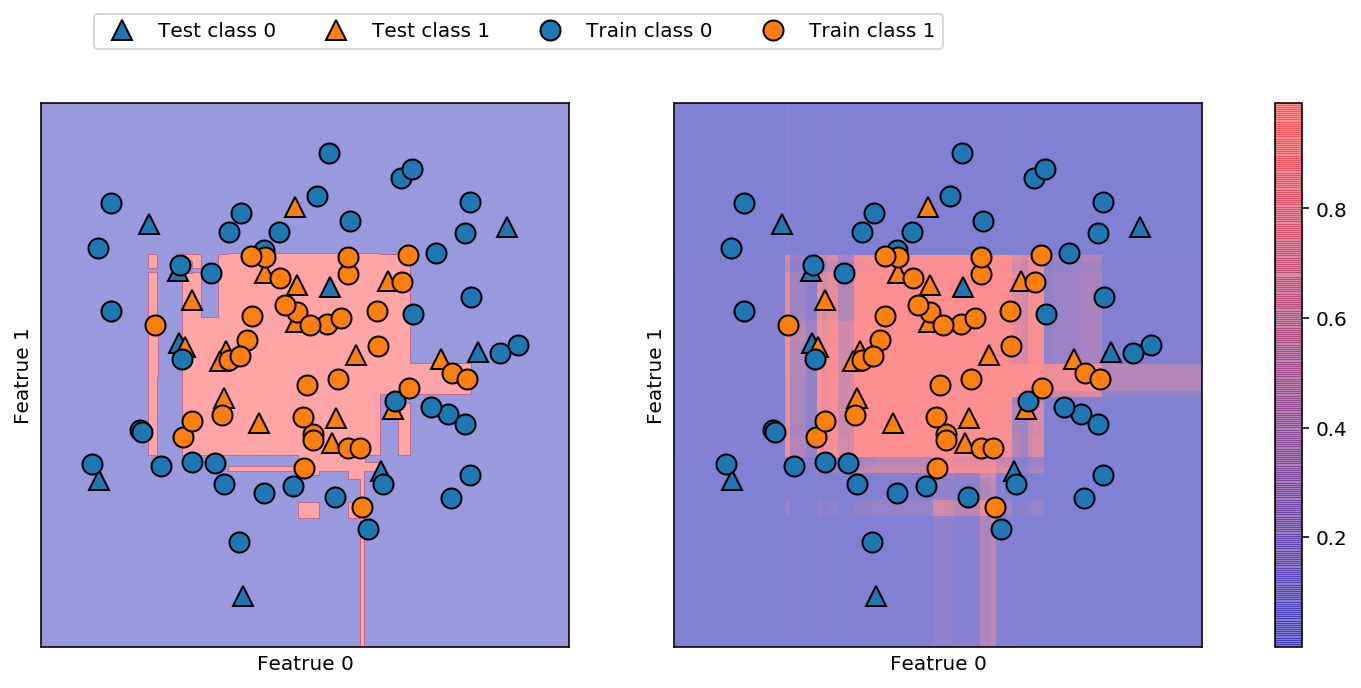

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(13, 5))

mglearn.tools.plot_2d_separator(gbrt, X, ax=axes[0], alpha=.4, fill=True, cm=mglearn.cm2)
scores_image = mglearn.tools.plot_2d_scores(gbrt, X, ax=axes[1], alpha=.5,  cm=mglearn.ReBl, function='predict_proba')

for ax in axes:
    # 訓練データポイントとテストデータポイントをプロット
    # plot training and test points
    mglearn.discrete_scatter(X_test[:, 0], X_test[:, 1], y_test, markers='^', ax=ax)
    mglearn.discrete_scatter(X_train[:, 0], X_train[:, 1], y_train, markers='o', ax=ax)
    ax.set_xlabel("Featrue 0")
    ax.set_ylabel("Featrue 1")

cbar = plt.colorbar(scores_image, ax=axes.tolist())
axes[0].legend(["Test class 0", "Test class 1", "Train class 0", "Train class 1"], ncol=4, loc=(.1, 1.1))

- この図では境界がはっきりしている

他クラス分類の不確実性
---
- decision_functionとpredict_probaメソッドは他クラス分類に対しても利用できる

### irisデータセットの動作(3クラス分類)

In [13]:
from sklearn.datasets import load_iris

iris = load_iris()
X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, random_state=42)

gbrt = GradientBoostingClassifier(learning_rate=0.01, random_state=0)
gbrt.fit(X_train, y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.01, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=0, subsample=1.0, verbose=0,
              warm_start=False)

In [16]:
print("Decision function shape: {}".format(gbrt.decision_function(X_test).shape))
# 最初のいくつかの決定関数を表示
print("Decision function : \n {}".format(gbrt.decision_function(X_test)[:6, :]))

Decision function shape: (38, 3)
Decision function : 
 [[-0.52931069  1.46560359 -0.50448467]
 [ 1.51154215 -0.49561142 -0.50310736]
 [-0.52379401 -0.4676268   1.51953786]
 [-0.52931069  1.46560359 -0.50448467]
 [-0.53107259  1.28190451  0.21510024]
 [ 1.51154215 -0.49561142 -0.50310736]]


In [18]:
print("Argmax of decision function:\n{}".format(np.argmax(gbrt.decision_function(X_test), axis=1)))
print("Predictions:\n{}".format(gbrt.predict(X_test)))

Argmax of decision function:
[1 0 2 1 1 0 1 2 1 1 2 0 0 0 0 1 2 1 1 2 0 2 0 2 2 2 2 2 0 0 0 0 1 0 0 2 1
 0]
Predictions:
[1 0 2 1 1 0 1 2 1 1 2 0 0 0 0 1 2 1 1 2 0 2 0 2 2 2 2 2 0 0 0 0 1 0 0 2 1
 0]


- 他クラス問題の場合、decision_functionの結果は、(n_samples, n_classes)の形の配列になる
- 各列は個々のクラスに対する「確信度スコア」で大きいとそのクラスである可能性が高く、小さくなると可能性が低くなる

#### predict_proba

In [23]:
# predict_probbaの結果の最初の数行を表示
print("Predicted probabilities:\n{}".format(gbrt.predict_proba(X_test)[:6]))
# 各行の和が1になるか確認
print("Sums: {}".format(gbrt.predict_proba(X_test)[:6].sum(axis=1)))

Predicted probabilities:
[[0.10664722 0.7840248  0.10932798]
 [0.78880668 0.10599243 0.10520089]
 [0.10231173 0.10822274 0.78946553]
 [0.10664722 0.7840248  0.10932798]
 [0.10825347 0.66344934 0.22829719]
 [0.78880668 0.10599243 0.10520089]]
Sums: [1. 1. 1. 1. 1. 1.]


In [24]:
print("Argmax of predicted probabilities:\n{}".format(np.argmax(gbrt.predict_proba(X_test), axis=1)))
print("Predictions:\n{}".format(gbrt.predict(X_test)))

Argmax of predicted probabilities:
[1 0 2 1 1 0 1 2 1 1 2 0 0 0 0 1 2 1 1 2 0 2 0 2 2 2 2 2 0 0 0 0 1 0 0 2 1
 0]
Predictions:
[1 0 2 1 1 0 1 2 1 1 2 0 0 0 0 1 2 1 1 2 0 2 0 2 2 2 2 2 0 0 0 0 1 0 0 2 1
 0]


- predict_probaの出力も同じ(n_samples, n_classes)の形の配列となる
- 各クラスの確率の和は1になる